In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
from matplotlib import pyplot
from tensorflow.keras import models,layers,optimizers,utils
import sklearn

In [7]:


url="/content/4_5902416483643823943.csv"
names=['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset=pd.read_csv(url,names=names)

In [8]:
array=dataset.values

data=array[:,0:4]
print(data.shape)

labels=array[:,4]
print(labels.shape)


(150, 4)
(150,)


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
labels = encoder.fit_transform(labels)

print(labels)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [10]:
labels=pd.get_dummies(labels).values
labels[:5]

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [11]:
data = np.asarray(data).astype('float32')

In [12]:
from sklearn.model_selection import train_test_split

train_data, validation_data, train_labels, validation_labels=train_test_split(data,labels, test_size=0.20, random_state=1)


In [13]:
print("Train Data Shape: ",train_data.shape)
print("Train Labels Shape: ",train_labels.shape)
print("Validation Data Shape: ",validation_data.shape)
print("validation labels Shape: ",validation_labels.shape)

Train Data Shape:  (120, 4)
Train Labels Shape:  (120, 3)
Validation Data Shape:  (30, 4)
validation labels Shape:  (30, 3)


In [14]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
loss_function = tf.keras.losses.CategoricalCrossentropy()


In [15]:


def fitness_function(weights, model, loss_function, x_train, y_train):
    # Split the weights into four parts for each layer
    input_size = 4
    weights_1_size = input_size * 16
    weights_2_size = 16 * 16
    weights_3_size = 16 * 8
    weights_4_size = 8 * 3

    weights_1 = weights[:weights_1_size].reshape((input_size, 16))
    weights_2 = weights[weights_1_size:weights_1_size + weights_2_size].reshape((16, 16))
    weights_3 = weights[weights_1_size + weights_2_size:weights_1_size + weights_2_size + weights_3_size].reshape((16, 8))
    weights_4 = weights[weights_1_size + weights_2_size + weights_3_size:].reshape((8, 3))

    # Set the weights of the model
    model.layers[0].set_weights([weights_1, np.zeros(16)])
    model.layers[1].set_weights([weights_2, np.zeros(16)])
    model.layers[2].set_weights([weights_3, np.zeros(8)])
    model.layers[3].set_weights([weights_4, np.zeros(3)])

    # Calculate the loss on the entire training dataset
    y_pred = model(x_train)
    loss = loss_function(y_train, y_pred)

    return loss.numpy()  # Assuming the loss function returns a tensor


In [16]:
vector_length=472
population_size=4720


In [17]:
import numpy as np

# Xavier Initialization for vectors
def xavier_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    var = 2.0 / shape  # Variance
    return np.random.randn(shape) * np.sqrt(var)  # Sample from Gaussian distribution

# He Initialization for vectors
def he_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    var = 2.0 / shape  # Variance
    return np.random.randn(shape) * np.sqrt(var)  # Sample from Gaussian distribution

# LeCun Initialization for vectors
def lecun_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    limit = np.sqrt(3.0 / shape)  # Limit
    return np.random.uniform(-limit, limit, shape)  # Sample from uniform distribution

# Orthogonal Initialization for vectors

def orthogonal_init(size):
    """
    Generate an orthogonal vector of the specified size.

    Args:
        size (int): Size of the weight vector to initialize.

    Returns:
        numpy.ndarray: An orthogonal vector with the specified size.
    """
    a = np.random.normal(0.0, 1.0, size)  # Generate random vector
    q, _ = np.linalg.qr(a.reshape(-1, 1))  # Compute QR decomposition
    return q.flatten()  # Return orthogonal vector as a 1D array


def generate_random_weights(size, min_value=-1.0, max_value=1.0):
    """
    Generate random float numbers for weights of a neural network.

    Args:
    - size (int): The size of the weight vector.
    - min_value (float, optional): The minimum value for the generated weights. Default is -1.0.
    - max_value (float, optional): The maximum value for the generated weights. Default is 1.0.

    Returns:
    - numpy.ndarray: A 1D array containing random float numbers within the specified range.
    """
    return np.random.uniform(min_value, max_value, size)



In [18]:
# Define the chromosome class to store genes and fitness
class chromosome:
    Genes = None
    Fitness = None
    def __init__(self, genes, fitness):
        self.Genes = genes
        self.Fitness = fitness

In [19]:
# Function to create the initial population

import time

def make_population(method, population_size):
    # Initialize the population on GPU
    with tf.device('/device:GPU:0'):
        vector_len = (28 * 28 * 512) + (512 * 10)

        # Initialize empty list for population
        population = []

        # Show progress bar (optional)
        from tqdm import tqdm  # Install tqdm library if needed
        pbar = tqdm(total=population_size)

        start_time = time.time()

            # Loop through the population size
        for i in range(population_size):
            # Create chromosome and fitness
            if method == 1:
                genes = xavier_init(vector_length)
            elif method == 2:
                genes = lecun_init (vector_length)
            else:
                genes = generate_random_weights(vector_length)

            fitness = fitness_function(genes, model, loss_function, train_data, train_labels)
            population.append(chromosome(genes, fitness))

            # Update progress bar (optional)
            pbar.update(1)

        # Print time taken (optional)
        end_time = time.time()
        print(f"Population creation completed in {end_time - start_time:.2f} seconds")

        # Close progress bar (optional)
        pbar.close()

    return population

population = make_population(3, population_size)


100%|██████████| 4720/4720 [00:50<00:00, 93.20it/s]

Population creation completed in 50.64 seconds


In [20]:
# Calculate fitness diversity
def calculate_fitness_diversity(population):
    # Extract fitness values from the population
    fitness_values = [individual.Fitness for individual in population]

    # Calculate the variance or standard deviation of fitness values
    fitness_variance = np.var(fitness_values)
    fitness_stddev = np.std(fitness_values)

    return fitness_variance, fitness_stddev

In [21]:
# Calculate fitness diversity
variance, stddev = calculate_fitness_diversity(population)

print("Fitness Variance:", variance)
print("Fitness Standard Deviation:", stddev)

Fitness Variance: 73.187485
Fitness Standard Deviation: 8.554969


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

def jade_interm(fitness_function, population, dim=4019200, NP=300, CR=0.9, F=0.8, max_gen=4000, max_stagnant_generations=100):
    improvement_threshold = 1e-5
    memory_CR, memory_F = [], []
    best_fitness_progress = []  # List to store the best fitness value at each generation
    stagnant_generations = 0
    best_individual = None
    previous_best_fitness = float('inf')

    for gen in range(max_gen):
        mutants = np.empty((NP, dim))
        modified_indices = set()  # Keep track of individuals modified in this generation

        for i in range(NP):
            r1, r2, r3 = np.random.choice([j for j in range(NP) if j != i], 3, replace=False)
            best_index = np.argmin([pop.Fitness for pop in population])

            # Mutation (DE/current-to-best/1)
            F = cauchy.rvs(loc=0.5, scale=0.1)  # F follows a Cauchy distribution
            mutant_genes = population[i].Genes + F * (population[best_index].Genes - population[i].Genes) + \
                           F * (population[r1].Genes - population[r2].Genes)
            mutants[i] = mutant_genes[:dim]  # Ensure the mutant genes have the correct dimension

        # Intermediate crossover
        for i in range(NP):
            cross_points = np.random.rand(dim) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True  # Ensure at least one crossover
            mutants[i] = np.where(cross_points, mutants[i], population[i].Genes)

        trial_genes = mutants
        trial_fitness = np.array([fitness_function(trial_genes[i], model, loss_function, train_data, train_labels) for i in range(NP)])

        improve_mask = trial_fitness < np.array([pop.Fitness for pop in population])
        for i in range(NP):
            if improve_mask[i]:
                population[i] = chromosome(trial_genes[i], trial_fitness[i])
                memory_CR.append(CR)
                memory_F.append(F)
                modified_indices.add(i)

        # Update CR and F based on successful parameters only
        if modified_indices:
            CR = (1 - 0.1) * CR + 0.1 * np.mean([memory_CR[i] for i in range(len(memory_CR))])
            F = (1 - 0.1) * F + 0.1 * np.mean([memory_F[i] for i in range(len(memory_F))])
        else:
            # Set default values for CR and F
            CR = 0.9
            F = 0.8

        best_fitness = min(population, key=lambda x: x.Fitness).Fitness
        best_fitness_progress.append(best_fitness)

        # Print progress
        print(f"Generation {gen + 1}/{max_gen} - Best Fitness: {best_fitness}")

        # Check if the fitness threshold is reached
        if best_fitness <= 0.08:
            print(f"Terminating due to fitness threshold reached.")
            break

        # Check for improvement stagnation
        if previous_best_fitness - best_fitness < improvement_threshold:
            stagnant_generations += 1
        else:
            stagnant_generations = 0

        if stagnant_generations >= max_stagnant_generations:
            print(f"Terminating due to {max_stagnant_generations} stagnant generations.")
            break

        previous_best_fitness = best_fitness

        # Plot the progression at intervals
        if gen % 10 == 0:
            plt.plot(range(1, gen + 2), best_fitness_progress[:gen + 1])
            plt.xlabel('Generation')
            plt.ylabel('Best Fitness')
            plt.title('Progression of JADE Algorithm')
            plt.grid(True)
            plt.show()

    return min(population, key=lambda x: x.Fitness)


In [23]:
import copy

def jade_multiple_runs(fitness_function, num_runs=30,dim=vector_length, NP=population_size, CR=0.9, F=0.8, max_gen=200):
    seeds = np.random.randint(1, 1000, size=num_runs)  # Generate random seeds for each run
    success_count = 0
    successful_seeds = []

    for i, seed in enumerate(seeds, start=1):
        np.random.seed(seed)  # Set the random seed for reproducibility
        print(f"Run {i}/{num_runs} - Random Seed: {seed}")

        # Generate a deep copy of the original population for this run
        population_copy = copy.deepcopy(population)

        # Run JADE algorithm with specified kwargs
        best_individual = jade_interm(fitness_function, population_copy, dim=vector_length, NP=population_size, CR=0.9, F=0.8, max_gen=200)

        # Check if the best fitness meets the success criteria
        if best_individual.Fitness <= 0.08:
            success_count += 1
            successful_seeds.append(seed)

    success_rate = success_count / num_runs * 100
    print(f"\nSuccess Rate: {success_rate:.2f}%")

    return successful_seeds


In [24]:
array=dataset.values

data=array[:,0:4]
print(data.shape)

labels=array[:,4]
print(labels.shape)


(150, 4)
(150,)


In [25]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
labels = encoder.fit_transform(labels)

print(labels)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [26]:
labels=pd.get_dummies(labels).values
labels[:5]

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [27]:
data = np.asarray(data).astype('float32')

In [28]:
from sklearn.model_selection import train_test_split

train_data, validation_data, train_labels, validation_labels=train_test_split(data,labels, test_size=0.20, random_state=1)


In [29]:
print("Train Data Shape: ",train_data.shape)
print("Train Labels Shape: ",train_labels.shape)
print("Validation Data Shape: ",validation_data.shape)
print("validation labels Shape: ",validation_labels.shape)

Train Data Shape:  (120, 4)
Train Labels Shape:  (120, 3)
Validation Data Shape:  (30, 4)
validation labels Shape:  (30, 3)


# Model

In [30]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
loss_function = tf.keras.losses.CategoricalCrossentropy()


In [31]:


def fitness_function(weights, model, loss_function, x_train, y_train):
    # Split the weights into four parts for each layer
    input_size = 4
    weights_1_size = input_size * 16
    weights_2_size = 16 * 16
    weights_3_size = 16 * 8
    weights_4_size = 8 * 3

    weights_1 = weights[:weights_1_size].reshape((input_size, 16))
    weights_2 = weights[weights_1_size:weights_1_size + weights_2_size].reshape((16, 16))
    weights_3 = weights[weights_1_size + weights_2_size:weights_1_size + weights_2_size + weights_3_size].reshape((16, 8))
    weights_4 = weights[weights_1_size + weights_2_size + weights_3_size:].reshape((8, 3))

    # Set the weights of the model
    model.layers[0].set_weights([weights_1, np.zeros(16)])
    model.layers[1].set_weights([weights_2, np.zeros(16)])
    model.layers[2].set_weights([weights_3, np.zeros(8)])
    model.layers[3].set_weights([weights_4, np.zeros(3)])

    # Calculate the loss on the entire training dataset
    y_pred = model(x_train)
    loss = loss_function(y_train, y_pred)

    return loss.numpy()  # Assuming the loss function returns a tensor


In [32]:
vector_length=472
population_size=4720


In [33]:
import numpy as np

# Xavier Initialization for vectors
def xavier_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    var = 2.0 / shape  # Variance
    return np.random.randn(shape) * np.sqrt(var)  # Sample from Gaussian distribution

# He Initialization for vectors
def he_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    var = 2.0 / shape  # Variance
    return np.random.randn(shape) * np.sqrt(var)  # Sample from Gaussian distribution

# LeCun Initialization for vectors
def lecun_init(shape):
    """
    Args:
    - shape (int): Size of the weight vector to initialize.
    """
    limit = np.sqrt(3.0 / shape)  # Limit
    return np.random.uniform(-limit, limit, shape)  # Sample from uniform distribution

# Orthogonal Initialization for vectors

def orthogonal_init(size):
    """
    Generate an orthogonal vector of the specified size.

    Args:
        size (int): Size of the weight vector to initialize.

    Returns:
        numpy.ndarray: An orthogonal vector with the specified size.
    """
    a = np.random.normal(0.0, 1.0, size)  # Generate random vector
    q, _ = np.linalg.qr(a.reshape(-1, 1))  # Compute QR decomposition
    return q.flatten()  # Return orthogonal vector as a 1D array


def generate_random_weights(size, min_value=-1.0, max_value=1.0):
    """
    Generate random float numbers for weights of a neural network.

    Args:
    - size (int): The size of the weight vector.
    - min_value (float, optional): The minimum value for the generated weights. Default is -1.0.
    - max_value (float, optional): The maximum value for the generated weights. Default is 1.0.

    Returns:
    - numpy.ndarray: A 1D array containing random float numbers within the specified range.
    """
    return np.random.uniform(min_value, max_value, size)



In [34]:
# Define the chromosome class to store genes and fitness
class chromosome:
    Genes = None
    Fitness = None
    def __init__(self, genes, fitness):
        self.Genes = genes
        self.Fitness = fitness

In [35]:
# Function to create the initial population

import time

def make_population(method, population_size):
    # Initialize the population on GPU
    with tf.device('/device:GPU:0'):
        vector_len = (28 * 28 * 512) + (512 * 10)

        # Initialize empty list for population
        population = []

        # Show progress bar (optional)
        from tqdm import tqdm  # Install tqdm library if needed
        pbar = tqdm(total=population_size)

        start_time = time.time()

            # Loop through the population size
        for i in range(population_size):
            # Create chromosome and fitness
            if method == 1:
                genes = xavier_init(vector_length)
            elif method == 2:
                genes = lecun_init (vector_length)
            else:
                genes = generate_random_weights(vector_length)

            fitness = fitness_function(genes, model, loss_function, train_data, train_labels)
            population.append(chromosome(genes, fitness))

            # Update progress bar (optional)
            pbar.update(1)

        # Print time taken (optional)
        end_time = time.time()
        print(f"Population creation completed in {end_time - start_time:.2f} seconds")

        # Close progress bar (optional)
        pbar.close()

    return population

population = make_population(3, population_size)


100%|██████████| 4720/4720 [00:49<00:00, 95.78it/s]

Population creation completed in 49.28 seconds


In [36]:
# Calculate fitness diversity
def calculate_fitness_diversity(population):
    # Extract fitness values from the population
    fitness_values = [individual.Fitness for individual in population]

    # Calculate the variance or standard deviation of fitness values
    fitness_variance = np.var(fitness_values)
    fitness_stddev = np.std(fitness_values)

    return fitness_variance, fitness_stddev

In [37]:
# Calculate fitness diversity
variance, stddev = calculate_fitness_diversity(population)

print("Fitness Variance:", variance)
print("Fitness Standard Deviation:", stddev)

Fitness Variance: 75.36601
Fitness Standard Deviation: 8.68136


**Mutation**:  **DE/current-to-best/1** mutation strategy, which is a common choice in JADE. The F parameter is adaptively updated and follows a Cauchy distribution, which is also typical in JADE.<br>
**Crossove**r:  **binomial** crossover with an adaptively updated CR parameter. This is again a standard choice in JADE.<br>
**Selection**: You’re using **greedy selection**, where an individual is replaced by its trial vector only if the trial vector has better fitness. This is the correct approach in DE.<br>
**Adaptive Parameters**: You’re updating the CR and F parameters based on successful parameters, which is a key feature of JADE. If no individuals are updated in a generation, you reset CR and F to their default values, which is a reasonable approach.<br>
**Stagnation Check**: You’re checking for stagnation in terms of improvement in the best fitness and terminate the algorithm if there are too many stagnant generations. This is a good strategy to prevent unnecessary computations when the algorithm is not making significant progress.

with interm crossover

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

def jade_interm(fitness_function, population, dim=4019200, NP=300, CR=0.9, F=0.8, max_gen=4000, max_stagnant_generations=100):
    improvement_threshold = 1e-5
    memory_CR, memory_F = [], []
    best_fitness_progress = []  # List to store the best fitness value at each generation
    stagnant_generations = 0
    best_individual = None
    previous_best_fitness = float('inf')

    for gen in range(max_gen):
        mutants = np.empty((NP, dim))
        modified_indices = set()  # Keep track of individuals modified in this generation

        for i in range(NP):
            r1, r2, r3 = np.random.choice([j for j in range(NP) if j != i], 3, replace=False)
            best_index = np.argmin([pop.Fitness for pop in population])

            # Mutation (DE/current-to-best/1)
            F = cauchy.rvs(loc=0.5, scale=0.1)  # F follows a Cauchy distribution
            mutant_genes = population[i].Genes + F * (population[best_index].Genes - population[i].Genes) + \
                           F * (population[r1].Genes - population[r2].Genes)
            mutants[i] = mutant_genes[:dim]  # Ensure the mutant genes have the correct dimension

        # Intermediate crossover
        for i in range(NP):
            cross_points = np.random.rand(dim) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True  # Ensure at least one crossover
            mutants[i] = np.where(cross_points, mutants[i], population[i].Genes)

        trial_genes = mutants
        trial_fitness = np.array([fitness_function(trial_genes[i], model, loss_function, train_data, train_labels) for i in range(NP)])

        improve_mask = trial_fitness < np.array([pop.Fitness for pop in population])
        for i in range(NP):
            if improve_mask[i]:
                population[i] = chromosome(trial_genes[i], trial_fitness[i])
                memory_CR.append(CR)
                memory_F.append(F)
                modified_indices.add(i)

        # Update CR and F based on successful parameters only
        if modified_indices:
            CR = (1 - 0.1) * CR + 0.1 * np.mean([memory_CR[i] for i in range(len(memory_CR))])
            F = (1 - 0.1) * F + 0.1 * np.mean([memory_F[i] for i in range(len(memory_F))])
        else:
            # Set default values for CR and F
            CR = 0.9
            F = 0.8

        best_fitness = min(population, key=lambda x: x.Fitness).Fitness
        best_fitness_progress.append(best_fitness)

        # Print progress
        print(f"Generation {gen + 1}/{max_gen} - Best Fitness: {best_fitness}")

        # Check if the fitness threshold is reached
        if best_fitness <= 0.08:
            print(f"Terminating due to fitness threshold reached.")
            break

        # Check for improvement stagnation
        if previous_best_fitness - best_fitness < improvement_threshold:
            stagnant_generations += 1
        else:
            stagnant_generations = 0

        if stagnant_generations >= max_stagnant_generations:
            print(f"Terminating due to {max_stagnant_generations} stagnant generations.")
            break

        previous_best_fitness = best_fitness

        # Plot the progression at intervals
        if gen % 10 == 0:
            plt.plot(range(1, gen + 2), best_fitness_progress[:gen + 1])
            plt.xlabel('Generation')
            plt.ylabel('Best Fitness')
            plt.title('Progression of JADE Algorithm')
            plt.grid(True)
            plt.show()

    return min(population, key=lambda x: x.Fitness)


In [40]:
import copy

def jade_multiple_runs(fitness_function, num_runs=30,dim=vector_length, NP=population_size, CR=0.9, F=0.8, max_gen=200):
    seeds = np.random.randint(1, 1000, size=num_runs)  # Generate random seeds for each run
    success_count = 0
    successful_seeds = []

    for i, seed in enumerate(seeds, start=1):
        np.random.seed(seed)  # Set the random seed for reproducibility
        print(f"Run {i}/{num_runs} - Random Seed: {seed}")

        # Generate a deep copy of the original population for this run
        population_copy = copy.deepcopy(population)

        # Run JADE algorithm with specified kwargs
        best_individual = jade_interm(fitness_function, population_copy, dim=vector_length, NP=population_size, CR=0.9, F=0.8, max_gen=200)

        # Check if the best fitness meets the success criteria
        if best_individual.Fitness <= 0.08:
            success_count += 1
            successful_seeds.append(seed)

    success_rate = success_count / num_runs * 100
    print(f"\nSuccess Rate: {success_rate:.2f}%")

    return successful_seeds


Run 1/30 - Random Seed: 253
Generation 1/200 - Best Fitness: 0.46075761318206787


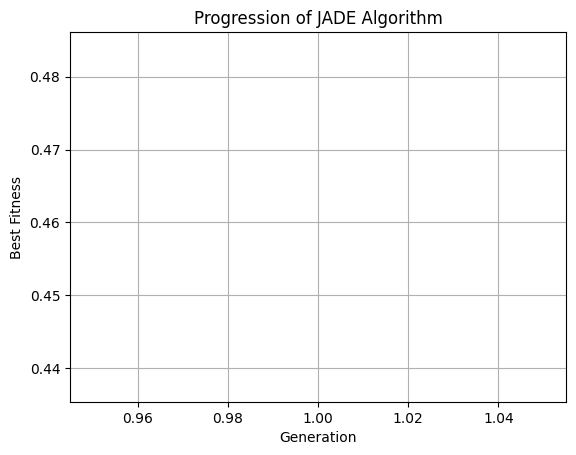

Generation 2/200 - Best Fitness: 0.44550660252571106
Generation 3/200 - Best Fitness: 0.19963571429252625
Generation 4/200 - Best Fitness: 0.19963571429252625
Generation 5/200 - Best Fitness: 0.158462792634964
Generation 6/200 - Best Fitness: 0.158462792634964
Generation 7/200 - Best Fitness: 0.158462792634964
Generation 8/200 - Best Fitness: 0.11512508988380432
Generation 9/200 - Best Fitness: 0.09818201512098312
Generation 10/200 - Best Fitness: 0.09717624634504318
Generation 11/200 - Best Fitness: 0.09717624634504318


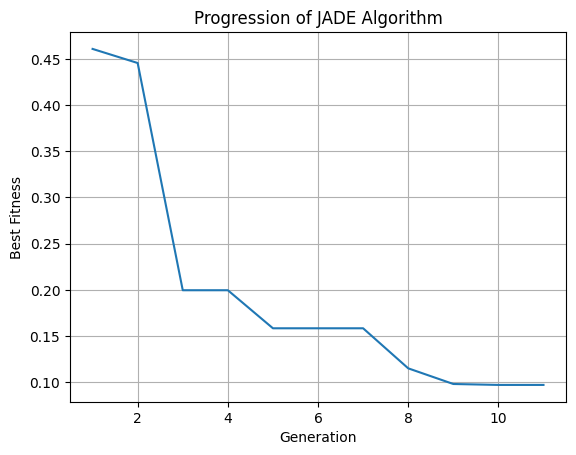

Generation 12/200 - Best Fitness: 0.09717624634504318
Generation 13/200 - Best Fitness: 0.09717624634504318
Generation 14/200 - Best Fitness: 0.09717624634504318
Generation 15/200 - Best Fitness: 0.09709354490041733
Generation 16/200 - Best Fitness: 0.0788392648100853
Terminating due to fitness threshold reached.
Run 2/30 - Random Seed: 781
Generation 1/200 - Best Fitness: 0.22743971645832062


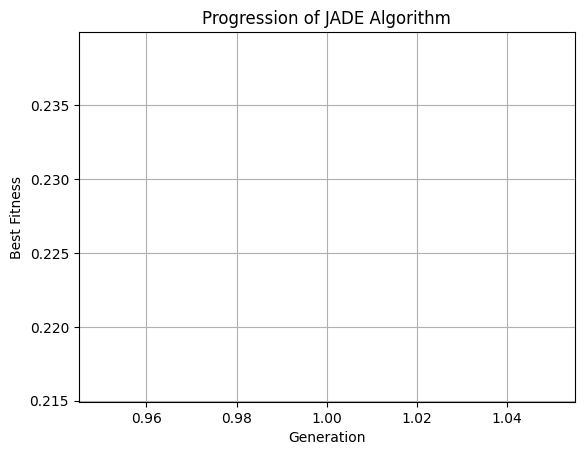

Generation 2/200 - Best Fitness: 0.22743971645832062
Generation 3/200 - Best Fitness: 0.21579958498477936
Generation 4/200 - Best Fitness: 0.14407402276992798
Generation 5/200 - Best Fitness: 0.14407402276992798
Generation 6/200 - Best Fitness: 0.12034675478935242
Generation 7/200 - Best Fitness: 0.11766789853572845
Generation 8/200 - Best Fitness: 0.11766789853572845
Generation 9/200 - Best Fitness: 0.11766789853572845
Generation 10/200 - Best Fitness: 0.11766789853572845
Generation 11/200 - Best Fitness: 0.11766789853572845


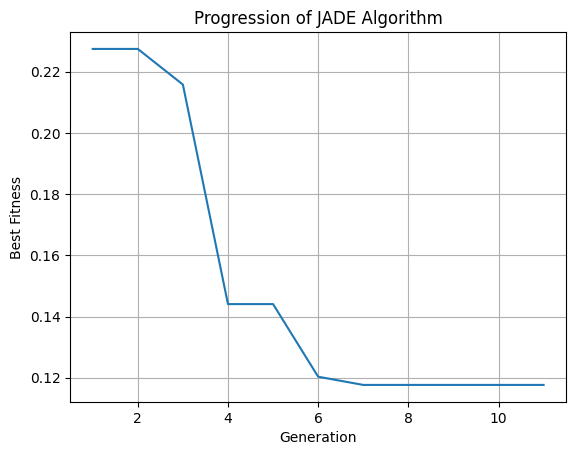

Generation 12/200 - Best Fitness: 0.11766789853572845
Generation 13/200 - Best Fitness: 0.11766789853572845
Generation 14/200 - Best Fitness: 0.11766789853572845
Generation 15/200 - Best Fitness: 0.0870339423418045
Generation 16/200 - Best Fitness: 0.08693333715200424
Generation 17/200 - Best Fitness: 0.08693333715200424
Generation 18/200 - Best Fitness: 0.08693333715200424
Generation 19/200 - Best Fitness: 0.08693333715200424
Generation 20/200 - Best Fitness: 0.08693333715200424
Generation 21/200 - Best Fitness: 0.08693333715200424


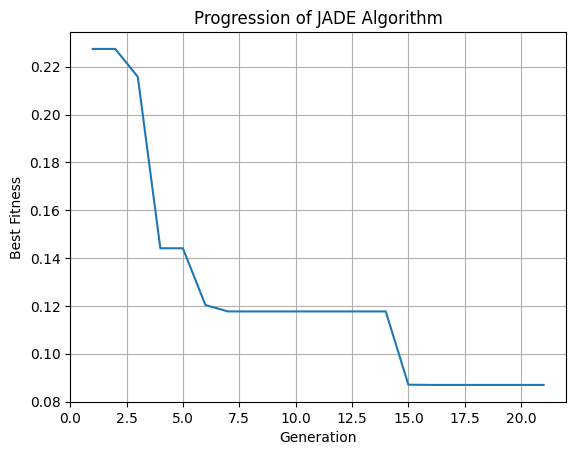

Generation 22/200 - Best Fitness: 0.08693333715200424
Generation 23/200 - Best Fitness: 0.08693333715200424
Generation 24/200 - Best Fitness: 0.08663425594568253
Generation 25/200 - Best Fitness: 0.07798287272453308
Terminating due to fitness threshold reached.
Run 3/30 - Random Seed: 121
Generation 1/200 - Best Fitness: 0.427658349275589


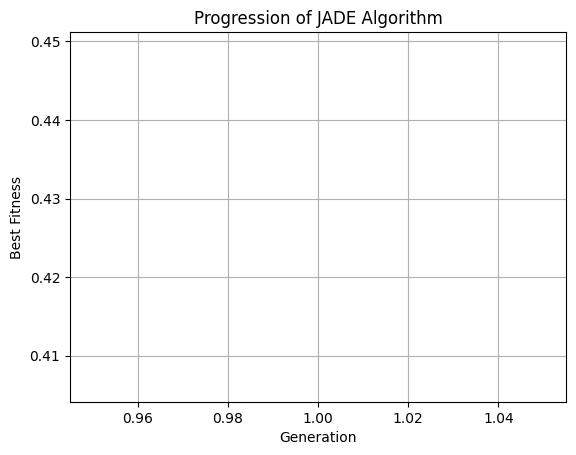

Generation 2/200 - Best Fitness: 0.32079485058784485
Generation 3/200 - Best Fitness: 0.32079485058784485
Generation 4/200 - Best Fitness: 0.32079485058784485
Generation 5/200 - Best Fitness: 0.15823782980442047
Generation 6/200 - Best Fitness: 0.15683287382125854
Generation 7/200 - Best Fitness: 0.15683287382125854
Generation 8/200 - Best Fitness: 0.11447159945964813
Generation 9/200 - Best Fitness: 0.10870783776044846
Generation 10/200 - Best Fitness: 0.09782528877258301
Generation 11/200 - Best Fitness: 0.09782528877258301


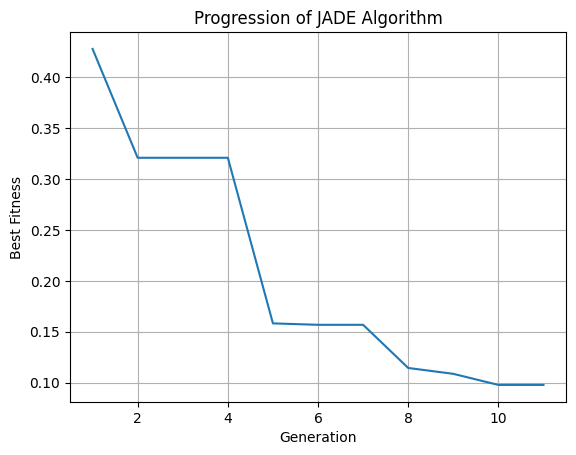

Generation 12/200 - Best Fitness: 0.09529367089271545
Generation 13/200 - Best Fitness: 0.09529367089271545
Generation 14/200 - Best Fitness: 0.09529367089271545
Generation 15/200 - Best Fitness: 0.09365345537662506
Generation 16/200 - Best Fitness: 0.09365345537662506
Generation 17/200 - Best Fitness: 0.09365345537662506
Generation 18/200 - Best Fitness: 0.09365345537662506
Generation 19/200 - Best Fitness: 0.09164341539144516
Generation 20/200 - Best Fitness: 0.08077608793973923
Generation 21/200 - Best Fitness: 0.08077608793973923


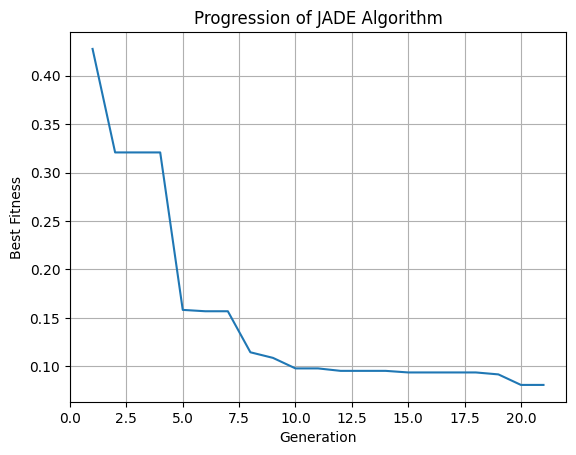

Generation 22/200 - Best Fitness: 0.08077608793973923
Generation 23/200 - Best Fitness: 0.08077608793973923
Generation 24/200 - Best Fitness: 0.08077608793973923
Generation 25/200 - Best Fitness: 0.08077608793973923
Generation 26/200 - Best Fitness: 0.08077608793973923
Generation 27/200 - Best Fitness: 0.0767035037279129
Terminating due to fitness threshold reached.
Run 4/30 - Random Seed: 177
Generation 1/200 - Best Fitness: 0.389705091714859


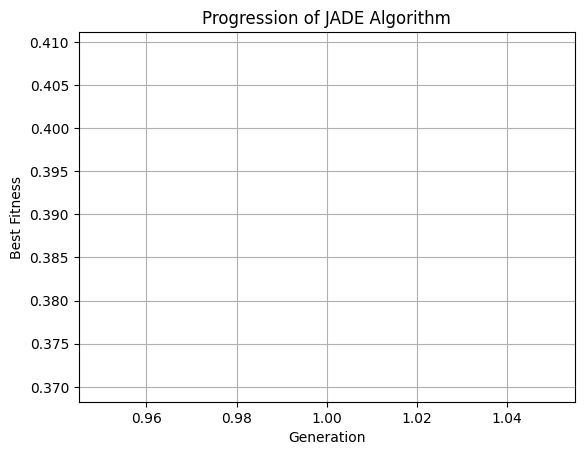

Generation 2/200 - Best Fitness: 0.389705091714859
Generation 3/200 - Best Fitness: 0.2616884112358093
Generation 4/200 - Best Fitness: 0.2616884112358093
Generation 5/200 - Best Fitness: 0.2616884112358093
Generation 6/200 - Best Fitness: 0.2616884112358093
Generation 7/200 - Best Fitness: 0.20914573967456818
Generation 8/200 - Best Fitness: 0.20914573967456818
Generation 9/200 - Best Fitness: 0.12802337110042572
Generation 10/200 - Best Fitness: 0.12802337110042572
Generation 11/200 - Best Fitness: 0.12802337110042572


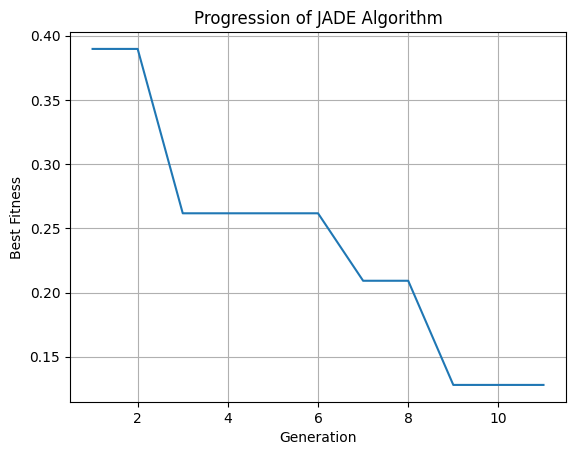

Generation 12/200 - Best Fitness: 0.11619046330451965
Generation 13/200 - Best Fitness: 0.11619046330451965
Generation 14/200 - Best Fitness: 0.11619046330451965
Generation 15/200 - Best Fitness: 0.11619046330451965
Generation 16/200 - Best Fitness: 0.11619046330451965
Generation 17/200 - Best Fitness: 0.11554167419672012
Generation 18/200 - Best Fitness: 0.11554167419672012
Generation 19/200 - Best Fitness: 0.11554167419672012
Generation 20/200 - Best Fitness: 0.11554167419672012
Generation 21/200 - Best Fitness: 0.11554167419672012


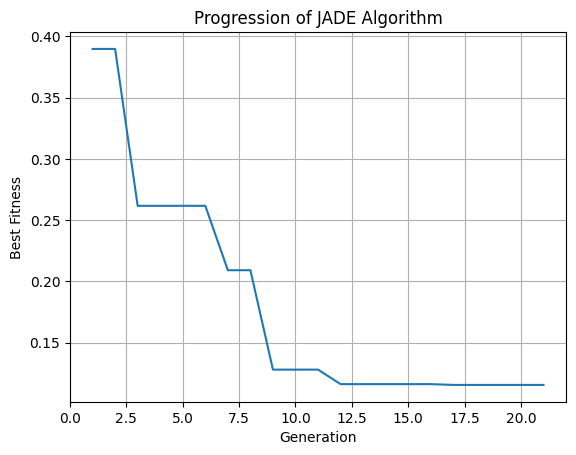

Generation 22/200 - Best Fitness: 0.11554167419672012
Generation 23/200 - Best Fitness: 0.11554167419672012
Generation 24/200 - Best Fitness: 0.11554167419672012
Generation 25/200 - Best Fitness: 0.11554167419672012
Generation 26/200 - Best Fitness: 0.11554167419672012
Generation 27/200 - Best Fitness: 0.11554167419672012
Generation 28/200 - Best Fitness: 0.11554167419672012
Generation 29/200 - Best Fitness: 0.11299475282430649
Generation 30/200 - Best Fitness: 0.11299475282430649
Generation 31/200 - Best Fitness: 0.11299475282430649


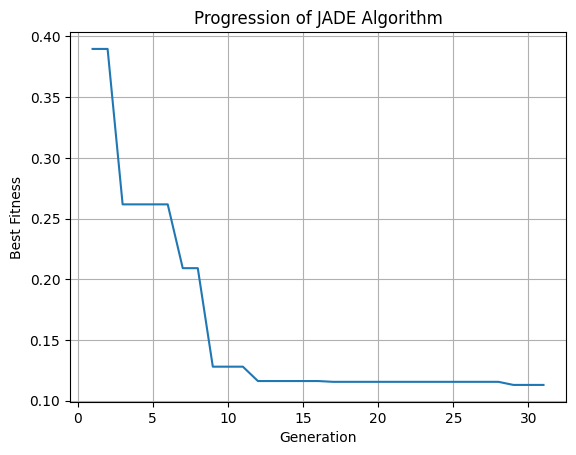

Generation 32/200 - Best Fitness: 0.11299475282430649
Generation 33/200 - Best Fitness: 0.11299475282430649
Generation 34/200 - Best Fitness: 0.0947817787528038
Generation 35/200 - Best Fitness: 0.0947817787528038
Generation 36/200 - Best Fitness: 0.0947817787528038
Generation 37/200 - Best Fitness: 0.0947817787528038
Generation 38/200 - Best Fitness: 0.0947817787528038
Generation 39/200 - Best Fitness: 0.0947817787528038
Generation 40/200 - Best Fitness: 0.0947817787528038
Generation 41/200 - Best Fitness: 0.0947817787528038


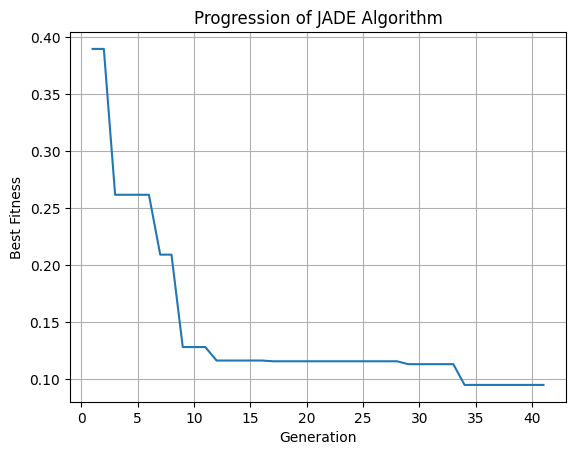

Generation 42/200 - Best Fitness: 0.09349799156188965
Generation 43/200 - Best Fitness: 0.08432645350694656
Generation 44/200 - Best Fitness: 0.08432645350694656
Generation 45/200 - Best Fitness: 0.08432645350694656
Generation 46/200 - Best Fitness: 0.08432645350694656
Generation 47/200 - Best Fitness: 0.08432645350694656
Generation 48/200 - Best Fitness: 0.08432645350694656
Generation 49/200 - Best Fitness: 0.08432645350694656
Generation 50/200 - Best Fitness: 0.08310801535844803
Generation 51/200 - Best Fitness: 0.08310801535844803


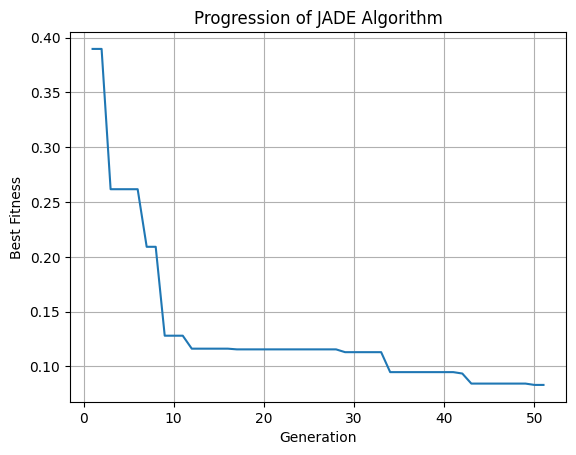

Generation 52/200 - Best Fitness: 0.08310801535844803
Generation 53/200 - Best Fitness: 0.08310801535844803
Generation 54/200 - Best Fitness: 0.07527004927396774
Terminating due to fitness threshold reached.
Run 5/30 - Random Seed: 991
Generation 1/200 - Best Fitness: 0.3379096984863281


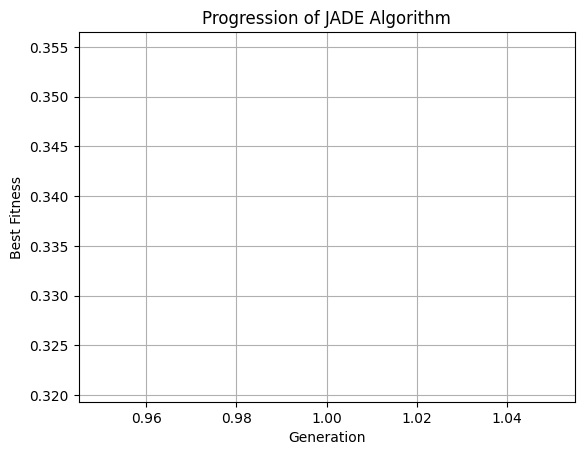

Generation 2/200 - Best Fitness: 0.114943727850914
Generation 3/200 - Best Fitness: 0.114943727850914
Generation 4/200 - Best Fitness: 0.114943727850914
Generation 5/200 - Best Fitness: 0.114943727850914
Generation 6/200 - Best Fitness: 0.08867451548576355
Generation 7/200 - Best Fitness: 0.08867451548576355
Generation 8/200 - Best Fitness: 0.08867451548576355
Generation 9/200 - Best Fitness: 0.08867451548576355
Generation 10/200 - Best Fitness: 0.07991210371255875
Terminating due to fitness threshold reached.
Run 6/30 - Random Seed: 677
Generation 1/200 - Best Fitness: 0.2988208830356598


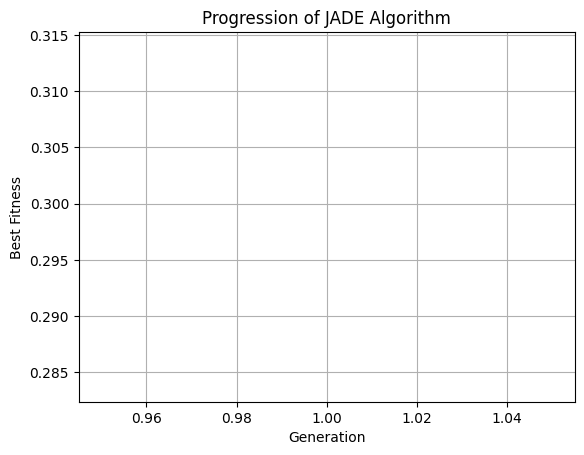

Generation 2/200 - Best Fitness: 0.1336635947227478


KeyboardInterrupt: 

In [43]:
success_rate1 = jade_multiple_runs(fitness_function, num_runs=30, dim=vector_length, NP=population_size, CR=0.9, F=0.8, max_gen=200)
